# **6.047 | 6.878 | HST.507**

#**Fall 2021 Problem Set 1: Aligning and Modeling Genomes**

Due: Monday, September 27 at 11:59PM (submit copy of notebook to Stellar)

#Load libraries


In [2]:
from google.colab import files
from math import log
import matplotlib.pyplot as plt
import io, random

#Evolutionary distances of orthologs and paralogs

In this problem, you will implement the Needleman-Wunsch algorithm for pairwise sequence alignment, apply it to the protein-coding sequences of related genes from several mammalian genomes, and use the results to learn about their evolution.

**A) Below is a python skeleton program that you need to complete. We provide a traceback routine, but you will write the code to fill in the score and traceback matrices. The skeleton program specifies a substitution matrix and gap penalty.**

In [3]:
base_idx = { 'A' : 0, 'G' : 1, 'C' : 2, 'T' : 3 }
PTR_NONE, PTR_GAP1, PTR_GAP2, PTR_BASE = 0, 1, 2, 3
S = [
	# A  G   C   T
	[3, -1, -2, -2], # A
	[-1, 3, -2, -2], # G
	[-2, -2, 3, -1], # C
	[-2, -2, -1, 3]  # T
	]
gap_pen = 4

def readSeq(file):
	"""reads in a FASTA sequence"""
	seq = []
	for line in file.splitlines():
		if line.startswith(">"):
			continue
		seq.append(line.rstrip())
	return "".join(seq)
 
def traceback(seq1,seq2,TB):
	s1, s2 = "", ""
	i, j = len(seq1), len(seq2)
	while TB[i][j] != PTR_NONE:
		if TB[i][j] == PTR_BASE:
			s1 = seq1[i-1] + s1
			s2 = seq2[j-1] + s2
			i -= 1
			j -= 1
		elif TB[i][j] == PTR_GAP1:
			s1 = '-' + s1
			s2 = seq2[j-1] + s2
			j -= 1
		elif TB[i][j] == PTR_GAP2:
			s1 = seq1[i-1] + s1
			s2 = '-' + s2
			i -= 1
		else: assert False

	return s1, s2

def getResults(seq1,seq2):
	score, F, TB = seqalignDP(seq1, seq2, S, gap_pen)
	s1, s2 = traceback(seq1, seq2, TB)
	return score, F, TB, s1, s2

def seqalignDP(seq1,seq2,subst_matrix,gap_pen):
	"""return the score of the optimal Needleman-Wunsch alignment for seq1 and seq2
	Note: gap_pen should be positive (it is subtracted)
	"""
	F = [[0 for j in range(len(seq2) + 1)] for i in range(len(seq1) + 1)]
	TB = [[PTR_NONE for j in range(len(seq2) + 1)] for i in range(len(seq1) + 1)]

	# initialize dynamic programming table for Needleman-Wunsch alignment (Durbin p.20)
	for i in range(1,len(seq1) + 1):
		F[i][0] = 0 - i * gap_pen
		TB[i][0] = PTR_GAP2 # indicates a gap in seq2
	for j in range(1,len(seq2) + 1):
		F[0][j] = 0 - j * gap_pen
		TB[0][j] = PTR_GAP1 # indicates a gap in seq1

	for i in range(1, len(seq1) + 1):
		for j in range(1, len(seq2) + 1):
			mis_match=F[i-1][j-1] + S[base_idx[seq1[i-1]]][base_idx[seq2[j-1]]]
			gap1=F[i][j-1] - gap_pen
			gap2=F[i-1][j] - gap_pen
			F[i][j] = max(mis_match, gap1, gap2)
	 		
	
			direction = max(F[i-1][j-1], F[i][j-1], F[i-1][j])
			if direction == F[i-1][j-1]:
				TB[i-1][j-1] = PTR_BASE
			elif direction == F[i][j-1]:
				TB[i-1][j-1] = PTR_GAP2
			elif direction == F[i-1][j]:
				TB[i-1][j-1] = PTR_GAP1
				
	return F[len(seq1)][len(seq2)], F, TB

**B) Run the following code block to evaluate your Needleman-Wunsch algorithm implementation on two relatively simple sequences. If you make any edits to the code block, please restore it to the original version before turning it in.**

In [30]:
seq1, seq2 = "CTAAGTACT", "CATTA"

score, F, TB, s1, s2 = getResults(seq1, seq2)

print("\n".join([str(score), s1, s2]))
for line in F:
	print(line)


-6


[0, -4, -8, -12, -16, -20]
[-4, 3, -1, -5, -9, -13]
[-8, -1, 1, 2, -2, -6]
[-12, -5, 2, -1, 0, 1]
[-16, -9, -2, 0, -3, 3]
[-20, -13, -6, -4, -2, -1]
[-24, -17, -10, -3, -1, -4]
[-28, -21, -14, -7, -5, 2]
[-32, -25, -18, -11, -8, -2]
[-36, -29, -22, -15, -8, -6]


The Hox cluster is a set of genes that are crucial in determining body plan formation during embryo development. They are found in all bilateral animals, in species as distant as the fruit fly. The fruit fly has one Hox cluster, while most vertebrates have four. It is thought that vertebrates have undergone two rounds of whole-genome duplication, giving rise to four Hox clusters from the ancestral one, although the hypothesis remains controversial.

In the remainder of this problem, you will use your Needleman-Wunsch implementation to analyze the sequences of several Hox genes, and estimate the date of the most recent vertebrate whole-genome duplication. In particular, we are interested in using the N-W alignment score as a distance metric between two sequences.

You will need to download the following [files](https://www.dropbox.com/sh/n0mhoinyc6vyhg4/AABJxeDjhF8RG-YBh1JTRTeia?dl=0) and upload them to colab using the following code block.

In [26]:
hox_fa = files.upload()
for k, v in hox_fa.items():
    hox_fa[k] = readSeq(v.decode("utf-8"))

Saving human_HoxA13.fa to human_HoxA13.fa
Saving human_HoxD13.fa to human_HoxD13.fa
Saving mouse_HoxA13.fa to mouse_HoxA13.fa
Saving mouse_HoxD13.fa to mouse_HoxD13.fa


**C) Make minor adjustments to your Needleman-Wunsch algorithm so that the score it computes can be interpreted as a distance metric. That is, the score of a sequence aligned with itself should be zero, all scores should be non-negative, and sequences that are more dissimilar should be given a score with a greater magnitude.**

In [31]:
S1 = [
	# A  G   C   T
	[0, 1, 2, 2], # A
	[1, 0, 2, 2], # G
	[2, 2, 0, 1], # C
	[2, 2, 1, 0]  # T
	]
	
def seqalignDP(seq1,seq2,subst_matrix,gap_pen):
	F = [[0 for j in range(len(seq2) + 1)] for i in range(len(seq1) + 1)]
	TB = [[PTR_NONE for j in range(len(seq2) + 1)] for i in range(len(seq1) + 1)]

	for i in range(1,len(seq1) + 1):
		F[i][0] = 0 + i * gap_pen
		TB[i][0] = PTR_GAP2
	for j in range(1,len(seq2) + 1):
		F[0][j] = 0 + j * gap_pen
		TB[0][j] = PTR_GAP1

	for i in range(1, len(seq1) + 1):
		for j in range(1, len(seq2) + 1):
			mis_match=F[i-1][j-1] + S1[base_idx[seq1[i-1]]][base_idx[seq2[j-1]]]
			gap1=F[i][j-1] + gap_pen
			gap2=F[i-1][j] + gap_pen
			F[i][j] = min(mis_match, gap1, gap2)
	 
			direction = min(F[i-1][j-1], F[i][j-1], F[i-1][j])
			if direction == F[i-1][j-1]:
				TB[i][j] = PTR_BASE
			elif direction == F[i][j-1]:
				TB[i][j] = PTR_GAP2
			elif direction == F[i-1][j]:
				TB[i][j] = PTR_GAP1
	
				
	return F[len(seq1)][len(seq2)], F, TB

**D) When you believe that your Needleman-Wunsch implementation has been adjusted appropriately, run the following code block to compute the distance between the human HoxA13 gene and the mouse HoxA13 gene.**

In [32]:
seq1, seq2 = hox_fa["human_HoxA13.fa"], hox_fa["mouse_HoxA13.fa"]

score, F, TB, s1, s2 = getResults(seq1, seq2)

print(score)

197


**E) The modern mammalian genes HoxA13 and HoxD13 arose from a single ancestral gene by whole-genome duplication, long before the human-mouse divergence. We provide the sequences of the human and mouse HoxD13 genes on the web site. Given that the fossil record shows that human and mouse diverged about 70 million years ago, use your distance metric and your results from part (C) to estimate the date of the whole-genome duplication that gave rise to HoxA13 and HoxD13. Make sure to state the assumptions underlying your estimate.**

In [33]:
seq1_1, seq2_1 = hox_fa["human_HoxA13.fa"], hox_fa["human_HoxD13.fa"]

score_1, F_1, TB_1, s1_1, s2_1 = getResults(seq1_1, seq2_1)

seq1_2, seq2_2 = hox_fa["mouse_HoxA13.fa"], hox_fa["mouse_HoxD13.fa"]

score_2, F_2, TB_2, s1_2, s2_2 = getResults(seq1_2, seq2_2)

print("between " + str(score_1*70/score) + " and " + str(score_2*70/score) + " million years")

between 406.8527918781726 and 389.0862944162437 million years


This answer assumes that the distance metric is proportionate to amount of dissimiliarity and that dissimiliarity is proportionate to time passed, allowing the use of the ratio of distance metric to time.

#Sequence hashing and dotplot visualization

As you have seen in the previous problem, sequence alignment is a quadratic time algorithm. Full sequence alignment is therefore only feasible for sequences near the length of a single gene. To align larger regions of a genome, heuristic approximations are typically used. In this problem, you will use hashing techniques to guide the alignment of a 1 megabase (1 million nucleotides) region surrounding the HoxA cluster in human (`human-hoxa-region.fa`) and mouse (`mouse-hoxa-region.fa`). You will use dotplots to visualize the performance of various hashing methodologies.

You will need to download the following [files](https://www.dropbox.com/sh/4bvkqibn4pt9dty/AABXPS8WMXfHswT2PIR8KdGXa?dl=0) and upload them to colab using the following code block.

In [4]:
hox_fa_add = files.upload()
for k, v in hox_fa_add.items():
    hox_fa_add[k] = readSeq(v.decode("utf-8"))

Saving human-hoxa-region-modified.fa to human-hoxa-region-modified.fa
Saving human-hoxa-region.fa to human-hoxa-region.fa
Saving mouse-hoxa-region.fa to mouse-hoxa-region.fa


The code block below finds all 30-mers in the human that also appear in mouse. On a dotplot, each of these matches is represented as a single dot at $(x,y)$, where $x$ is a coordinate for the beginning of a 30-mer in human and $y$ is a coordinate for the beginning of a matching 30-mer in mouse. We provide a plotting function that will produce dotplot images.  The format of the image is determined by the file extension (`.ps`, `.png`, `.jpg`). There is also code for heuristically judging the *specificity* of the matches (the fraction of matches that occur near the diagonal of the dotplot).

In [6]:
bp_dict = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}

def quality(hits):
    """determines the quality of a list of hits"""
    slope1 = 1.0e6 / (825000 - 48000)
    slope2 = 1.0e6 / (914000 - 141000)
    offset1 = 0 - slope1*48000
    offset2 = 0 - slope2*141000
    goodhits = []
    for hit in hits:
        upper = slope1 * hit[0] + offset1
        lower = slope2 * hit[0] + offset2
        if lower < hit[1] < upper:
            goodhits.append(hit)
    return goodhits

def makeDotplot(hits):
    """generate a dotplot from a list of hits
       filename may end in the following file extensions:
         *.ps, *.png, *.jpg
    """
    x, y = zip(* hits)
    slope1 = 1.0e6 / (825000 - 48000)
    slope2 = 1.0e6 / (914000 - 141000)
    offset1 = 0 - slope1*48000
    offset2 = 0 - slope2*141000
    hits2 = quality(hits)

    # create plot
    plt.scatter(x, y, marker = "+", color = "purple")
    plt.xlabel("sequence2")
    plt.xlim(0, 1e6)
    plt.ylabel("sequence 1")
    plt.ylim(0, 1e6)
    plt.title("dotplot (%d hits, %.5f%% hits on diagonal)" %
              (len(hits), 100 * len(hits2) / float(len(hits))))
    plt.plot(x, [slope1 * val + offset1 for val in x], color = "blue")
    plt.plot(x, [slope2 * val + offset2 for val in x], color = "blue")

    return

**A) Run the following code block unchanged to generate a dotplot for all exact matching 30-mers.**

**Describe what you see. How many hits are there and what percentage fall near the diagonal? Do you observe any structure in the off-diagonal hits? What types of genomic elements could cause such a pattern? Why are matches that are close to the diagonal more likely than off-diagonal matches to represent "correct", or orthologous, alignments?**

hashing seq1
hashing seq2


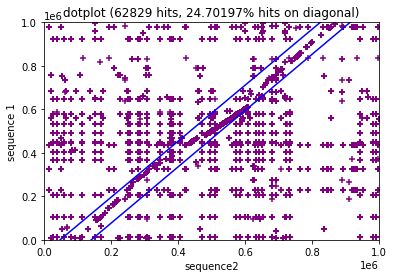

In [35]:
seq1 = readSeq(hox_fa_add["human-hoxa-region.fa"])
seq2 = readSeq(hox_fa_add["mouse-hoxa-region.fa"])
kmerlen = 30

print("hashing seq1")
lookup = {}
for i in range(len(seq1) - kmerlen + 1):
    key = seq1[i:i + kmerlen]
    lookup.setdefault(key, []).append(i)

print("hashing seq2")
hits = []
for i in range(len(seq2) - kmerlen + 1):
    key = seq2[i:i + kmerlen]
    for hit in lookup.get(key, []):
        hits.append((i, hit))

makeDotplot(hits)

62829 hits, 24.702% along the diagonal.

Off-diagonal hits occur in vertical/horizontal segments, indicating some 30-mer identified in sequence 2 is repeated many times within a short segment of sequence 1, or vice versa. This may be due to tandem repeats and/or mini-satellite DNA (found in the centromeres. repetitive elements in each genome. Spotted column or row formations may indicate interspersed repetitive DNA. Some may also represent true orthologs, where rearrangements in genomic structure or ancient duplications may result in off-diagonal orthologs or homologous sequnces with dissimilar functions, respectively.

Conversely, hits along the diagonal are more likely to indicate orthologs since mice and humans are both mammals, sharing some common ancestor, and therefore likely have similar organization of genetic elements.

**B) Make the following modifications to the script and report how the plot changes qualitatively and quantatively (how many hits, what percentage are near the diagonal). Also briefly describe how you implemented each change.**

1. **Modify the script to find all *exact* matching 100-mers**
2. **Modify the script to find all 60-mers that match every *other* base**
3. **Modify the script to find all 90-mers that match every *third* base**
4. **Modify the script to find all 120-mers that match every *fourth* base**
5. **Modify the script to find all 100-mers that allow at *most two* mismatches in each contiguous block of six bases. Instead of modifying the script and generating the plot, focus on describing how you would implement this modification.**

**Use the following code and text block to implement your changes and record your results, respectively.**



hashing seq1
hashing seq2


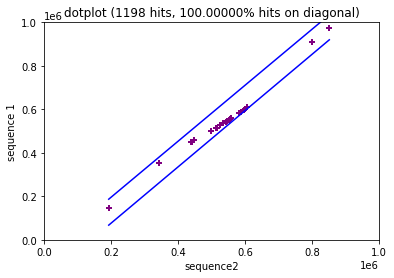

In [36]:
seq1 = readSeq(hox_fa_add["human-hoxa-region.fa"])
seq2 = readSeq(hox_fa_add["mouse-hoxa-region.fa"])
kmerlen = 100

print("hashing seq1")
lookup = {}
for i in range(len(seq1) - kmerlen + 1):
    key=seq1[i:i + kmerlen]
    lookup.setdefault(key, []).append(i)

print("hashing seq2")
hits = []
for i in range(len(seq2) - kmerlen + 1):
    key = seq2[i:i + kmerlen]
    for hit in lookup.get(key, []):
        hits.append((i, hit))

makeDotplot(hits)

1. 1198 hits, 100% along diagonal; there are much fewer hits, but they only appear along the diagonal because the genes they encode must be perfectly conserved down to the nucleotide. Implementation consisted of changing the k-mer length to 100.
2. 23933 hits, 38.741% along diagonal; there are many more hits, most not along the diagonal, suggesting that although the current parameters are very sensitive, searching for k-mers >60 bp may increase guarantee specifity. Implementation consisted of changing k-mer length to 60 and increasing the step-size to 2 in the slicing of the sequence arrays.
3. 8887 hits, 93.856% along diagonal; this has a high degree of specificity due to the step-size chosen, although sensitivity dramatically drops off. Implementation consisted of increasing k-mer length to 90 and increasing step-size to 3.
4. 6044 hits, 82.131% along diagonal; both specificity and sensitivity drop off, due to both the increasing k-mer length needed for a hit and the step-size, which has less correlation to specificity.
5. Hashing each 100-mer in sequence 1 consists of creating a tree with the first 6-mer, branching into $6 \choose 2$ wildcard placements in the first 6-mer, then creating a tree whose branches indicate the next nucleotide in the 100-mer being the corresponding nucleotide and/or a wildcard, determined by removing the first nucleotide in the 6-mer, which can be either a nucleotide or a wildcard.  Then leaves of the tree represent all possible configurations of 100-mers with 2-in-6 wildcards, all added to the lookup dictionary using the same location as the value. The same process is repeated for sequence 2, then hits are identified by lookup as is performed in previous k-mer searches.

**C) Although parts a, b.ii, b.iii, and b.iv require the same number of matching bases (30 = 60/2 = 90/3 = 120/4), one of them is more specific to the diagonal. Explain why this might be so.**

Matching every third base has the most biological significance since it corresponds to the conservation of some index of each codon. The first index is the greatest determinant of the corresponding amino acid. Thus, in order to match across 90 base pairs, it is more likely to match the first or second bases of each of the 30 codons in orthologous alignment, than the last codon, which often varies even in orthologs.

**D) Explain the trade-off you see between number of hits near the diagonal (sensitivity) and the percentage of hits near the diagonal (specificity). How is the trade-off affected by the hashing parameters?**

Sensitivity is dependent on the k-mer length chosen; smaller sizes are able to pick up more hits and thus the number of hits near the diagonal increases. Specificity is more dependent on the pattern of matching required; for example, matching every third has biological significance that returns more orthologous alignments.

**E) Modify the script to also detect inversions. An inversion occurs when a stretch of DNA is spliced out and reinserted in reverse orientation. For example,**

**CGT[GATT]AGA**

**CGT[TTAG]AGA**

**The `human-hoxa-region-modified.fa` file contains a version of the Hox region with an artificial inversion. Use the dotplot to locate the inversion in human. (Note: ignore the sensitivity measure, and only test all sizes necessary to detect the inversion). For convenience, the starter dotplot code is provided below.**



hashing seq1
hashing seq2


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



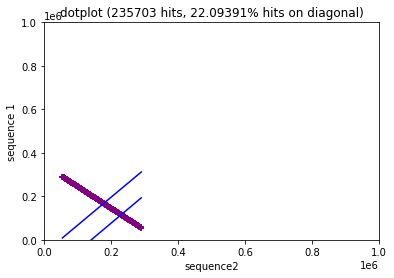

In [7]:
seq1 = readSeq(hox_fa_add["human-hoxa-region.fa"])
seq2 = readSeq(hox_fa_add["human-hoxa-region-modified.fa"])
kmerlen = 500

print("hashing seq1")
lookup = {}
for i in range(kmerlen, len(seq1) + 1):
    key=''
    for j in seq1[i:i-kmerlen:-1]:
      key+=bp_dict[j]
    lookup.setdefault(key, []).append(i)

print("hashing seq2")
hits = []
for i in range(len(seq2) - kmerlen + 1):
    key = seq2[i:i + kmerlen]
    for hit in lookup.get(key, []):
        hits.append((i, hit))
print(hits)
makeDotplot(hits)

The inversion is located from  to  .

#HMMs for GC-rich regions: State durations and limitations

An important use of HMMs is to decode or parse a genome into its biological components: exons, introns, regulatory regions, etc. In this problem, we will examine how the accuracy of HMM predictions is affected by certain inherent properties of the model.

In this problem, we will use GC content (the fraction of letters that are a C or a G) to classify the genome into high-GC regions (on average 60\% G or C) and Low-GC regions (on average 60\% A or T). These have different melting temperatures, different replication times across the cell cycle, and different gene density. They have also been hypothesized to have different evolutionary origins (see *isochores*}), but this hypothesis remains controversial.

**A) In most HMMs, the self-loop transition probabilities $a_{kk}$ are large, while the transition probabilities between different states $a_{kl}$ are small. Once a Markov chain with these transition probabilities enters state $k$, it tends to stay in state $k$ for a while. The *state duration* is the total number of consecutive steps at which the Markov chain stays in the same state, before switching to another state (e.g. transitioning into state $k$ and then transitioning out to a different state is a state duration of 1).  What is the expected (mean) state duration of state $k$ as a function of the transition probability $a_{kk}$? What is the distribution of state durations $P(D_{k}=d)$?**

Each transition occurs independently of each other, therefore the expected state duration for a sequence of length $N$ is $\sum_{i=1}^{N} i(a_{kk})^{i-1}a_{kl} = \frac{1}{1-a_{kk}}$. The distribution of state durations $P(D_k = d)$ is a geometric distribution with ratio $a_{kk}$. 

**B) Our simple model requires only two states. You will complete the code block below to implement the Viterbi algorithm.**

The nearly complete Viterbi algorithm does the following:

* Reads in a data file containing a DNA sequence and an authoritative (correct) annotation, consisting of a string of pluses and minuses, specifying where the High-GC and Low-GC regions are, respectively.
* Calculates the base composition of the High-GC and Low-GC regions and the mean length of High-GC and Low-GC regions. (All with respect to the authoritative annotation.)
* Performs Viterbi decoding on the DNA sequence, using a hard-coded HMM designed to detect High-GC and Low-GC regions. (This is the part you will complete.)
* Calculates the base composition of the High-GC and Low-GC regions and the mean length of High-GC and Low-GC regions. (All with respect to the Viterbi annotation.)
* Calculates the accuracy of the Viterbi decoding, defined as the percentage of predicted plus and minus states that match the authoritative annotation.

**This will allow you to decode several artificial genomes, and then compare the resulting predictions of High-GC and Low-GC regions to a provided (correct) annotation. Based on the HMM parameters hard-coded into the algorithm, what are the expected state durations for High-GC and Low-GC regions?**

The expected duration is $\frac{1}{0.01} = 100$ bp for High-GC and Low-GC regions.

In [8]:
###############################################################################
# HMM PARAMETERS
# Conventions: + refers to High-GC, and - refers to Low-GC. When indexing
#  states, 0 is + and 1 is -.
###############################################################################

state_idx = { '+' : 0, '-' : 1 }

# initial distribution over states, i.e. probability of starting in state k
init_dist = [0.5,0.5]

# transition probabilities
tr = [
    #  to+   to-
    [ 0.87, 0.13 ], # from+
    [ 0.13, 0.87 ]  # from-
]

# emission probabilities
em = [
    #    A     G     C     T
    [ 0.20, 0.30, 0.30, 0.20], # +
    [ 0.30, 0.20, 0.20, 0.30]  # -
]

###############################################################################
# ANNOTATION BENCHMARKING
###############################################################################

def basecomp(X, anno):
    counts = [[0] * 4, [0] * 4]
    for i in range(len(X)):
        counts[anno[i]][X[i]] += 1
    sum0 = sum(counts[0])
    sum1 = sum(counts[1])
    return [[x / sum0 for x in counts[0]], [x / sum1 for x in counts[1]]]

def region_lengths(anno):
    lengths = [[], []]
    curlen = 1
    for i in range(1, len(anno)):
        if anno[i] == anno[i - 1]:
            curlen += 1
        else:
            lengths[anno[i - 1]].append(curlen)
            curlen = 1
    lengths[anno[len(anno) - 1]].append(curlen)
    return lengths

def anno_accuracy(refanno, testanno):
    assert len(refanno) == len(testanno)
    return str(sum([x == y for x, y in zip(refanno, testanno)]) / len(refanno) * 100) + "%"

def basecomp_str(b):
    return "A=%.2f%% G=%.2f%% C=%.2f%% T=%.2f%%" % (100 * b[0], 100 * b[1], 100 * b[2], 100 * b[3])

def print_annostats(X, anno, label):
    lengths = region_lengths(anno)
    basecomps = basecomp(X,anno)

    print("High-GC mean region length: ", int(round(sum(lengths[0]) / len(lengths[0]))))
    print("High-GC base composition: ", basecomp_str(basecomps[0]))
    print("Low-GC mean region length: ", int(round(sum(lengths[1]) / len(lengths[1]))))
    print("Low-GC base composition: ", basecomp_str(basecomps[1]))

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
    ax1.set_title(label + " High-GC")
    ax1.hist(lengths[0], bins = 20)
    ax2.set_title(label + " Low-GC")
    ax2.hist(lengths[1], bins = 20)
    plt.show()
    
def print_summary(X, refanno, testanno):
    print("Authoritative annotation statistics")
    print("-----------------------------------")
    print_annostats(X, refanno, "Authoritative")
    print("")

    print("Viterbi annotation statistics")
    print("-----------------------------------")
    print_annostats(X, testanno, "Viterbi")
    print("")

    print("Accuracy: " + anno_accuracy(refanno, testanno))

###############################################################################
# VITERBI ALGORITHM (you must complete)
# Note: The length of the sequences we are dealing with is large enough that it
#       is necessary to use log-probabilities for numerical stability. You will
#       need to adapt the formulae accordingly.
###############################################################################

def viterbi(X):
    """Returns the Viterbi path for the emission sequence X.
    X should be a list of integers, 0=A, 1=G, 2=C, 3=T.
    The returned Y is a list of integers, 0=High-GC, 1=Low-GC.
    """
    N = len(tr)
    L = len(X)
    assert len(em) == N
    V = [[0]*N for _ in range(L)]
    TB = [[0]*N for _ in range(L)]
    for i in range(L):
        Vprev = []
        if i == 0:
            Vprev = [log(pk0) for pk0 in init_dist]
        else:
            Vprev = V[i-1]
        for k in range(N):
            prev_state=[(Vprev[j] + log(tr[j][k])) for j in range(N)]
            V[i][k]=log(em[k][X[i]]) + max(prev_state)

            if max(prev_state)==prev_state[0]:
              TB[i][k]=0
            else:
              TB[i][k]=1

    # perform traceback and return the predicted hidden state sequence
    Y = [-1 for i in range(L)]
    _, yL = max([ (V[L - 1][k], k) for k in range(N)])
    Y[L - 1] = yL
    for i in range(L - 2, -1, -1):
        Y[i] = TB[i + 1][Y[i + 1]]
    return Y

You will need to download the following [files](https://www.dropbox.com/sh/fvj6x0yxy6lpy6x/AAAb4Ufph_QgN3zlRBMAyyaqa?dl=0) and upload them to colab using the following code block.

In [3]:
hmm = files.upload()
for k, v in hmm.items():
    hmm[k] = v.decode("utf-8").split("\n")

Saving hmmgen to hmmgen
Saving mystery1 to mystery1
Saving mystery2 to mystery2
Saving mystery3 to mystery3


**C) Run the following code block to apply your Viterbi implementation to the data file `hmmgen`, which was generated using the same HMM, and verify that your program achieves 83% accuracy.**

Authoritative annotation statistics
-----------------------------------
High-GC mean region length:  100
High-GC base composition:  A=20.01% G=29.87% C=30.02% T=20.10%
Low-GC mean region length:  102
Low-GC base composition:  A=29.63% G=19.94% C=20.20% T=30.23%


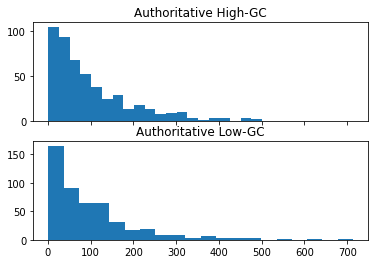


Viterbi annotation statistics
-----------------------------------
High-GC mean region length:  140
High-GC base composition:  A=18.97% G=30.79% C=31.10% T=19.14%
Low-GC mean region length:  135
Low-GC base composition:  A=30.99% G=18.70% C=18.80% T=31.51%


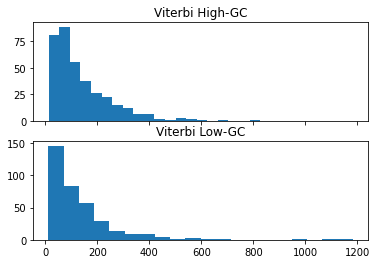


Accuracy: 86.468%


In [9]:
seq = [base_idx[bp] for bp in hmm['hmmgen'][0]]
ref = [state_idx[ann] for ann in hmm['hmmgen'][1]]
test = viterbi(seq)

print_summary(seq, ref, test)

**D) The following code block applies your Viterbi implementation to 3 mystery files (`mystery1`, `mystery2`, and `mystery3`). How do the (correct) state duration distributions in the mystery sequences differ and what do they have in common? What accuracy levels does your HMM achieve on these sequences? How does each Viterbi-predicted state duration distribution differ from the correct distribution?**

Authoritative annotation statistics
-----------------------------------
High-GC mean region length:  100
High-GC base composition:  A=19.94% G=29.87% C=30.20% T=20.00%
Low-GC mean region length:  101
Low-GC base composition:  A=29.87% G=20.27% C=19.73% T=30.13%


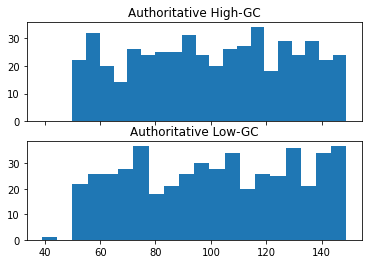


Viterbi annotation statistics
-----------------------------------
High-GC mean region length:  106
High-GC base composition:  A=18.62% G=31.11% C=31.38% T=18.90%
Low-GC mean region length:  98
Low-GC base composition:  A=31.78% G=18.47% C=17.94% T=31.81%


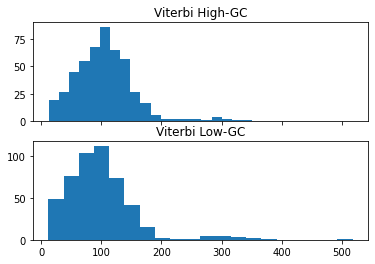


Accuracy: 84.097%


Authoritative annotation statistics
-----------------------------------
High-GC mean region length:  100
High-GC base composition:  A=19.85% G=29.78% C=30.07% T=20.30%
Low-GC mean region length:  100
Low-GC base composition:  A=29.84% G=19.86% C=19.99% T=30.31%


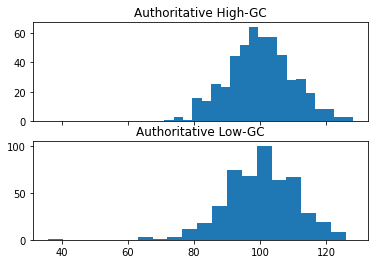


Viterbi annotation statistics
-----------------------------------
High-GC mean region length:  102
High-GC base composition:  A=18.51% G=31.12% C=31.48% T=18.89%
Low-GC mean region length:  94
Low-GC base composition:  A=31.69% G=18.00% C=18.06% T=32.24%


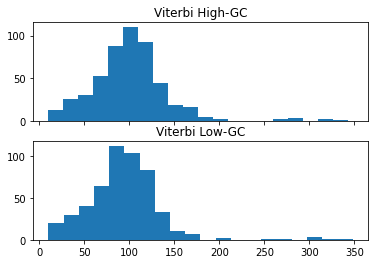


Accuracy: 84.089%


Authoritative annotation statistics
-----------------------------------
High-GC mean region length:  100
High-GC base composition:  A=19.81% G=29.71% C=30.56% T=19.91%
Low-GC mean region length:  100
Low-GC base composition:  A=29.56% G=20.09% C=20.11% T=30.24%


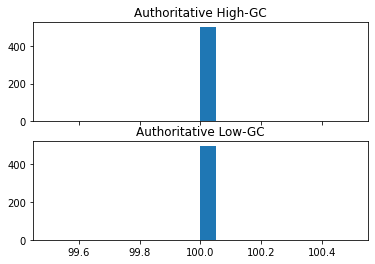


Viterbi annotation statistics
-----------------------------------
High-GC mean region length:  104
High-GC base composition:  A=18.63% G=31.08% C=31.74% T=18.55%
Low-GC mean region length:  93
Low-GC base composition:  A=31.44% G=18.01% C=18.19% T=32.37%


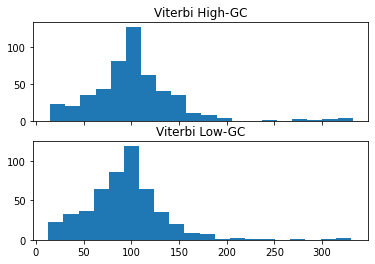


Accuracy: 82.504%




In [10]:
for i in range(1, 4):
    seq = [base_idx[bp] for bp in hmm['mystery' + str(i)][0]]
    ref = [state_idx[ann] for ann in hmm['mystery' + str(i)][1]]
    test = viterbi(seq)
    print_summary(seq, ref, test)
    print("\n")

**E) Would re-training the HMM parameters according to the procedure described in lecture, using the correct annotations as training data, improve the accuracy of the Viterbi annotation for the mystery sequences? Why or why not?**

**(Extra credit) Try to make the decoder perform better by adjusting the hard-coded model parameters. If you succeed, can you explain why?**

Training the HMM parameters on the hmmgen file would not help the annotation on the mystery files because their length distributions for High-GC and Low-GC regions differ dramatically from the hmmgen file. Retraining the HMM parameters on the authoritative annotation for the mystery files may not even help, since each mystery file has drastically different state duration distributions and will be unlikely to contribute to a better prediction.

Extra Credit: I improved the decoder by increasing the frequency of state transitions, since I noticed the Viterbi region lengths were consistently longer than that of the authoritative annotation, based on the mean length alone.

**F) As you are now aware, the length distribution of genomic elements can strongly affect the predictive accuracy of an HMM used to decode them. Unfortunately, most elements in real genomes do not follow the length distribution you derived in part (A). By reading the following paper (or any other sources), describe how the gene under GENSCAN addresses this issue. How is it possible, algorithmically, to use state duration distributions that differ from the one you derived in part (A)?**

**Burge C, Karlin S. Prediction of complete gene structures in human genomic DNA. J Mol Bio 268(1):78-94, 1997.**

GENSCAN classifies and trains its model based on the structure and sequence of elements of genomic sequences (e.g. promoter, single exon gene, multi-exon gene, intergenic region), specifying which transitions are possible, and trains on both forwards and reverse strands, the latter of which simply uses the reversed sequence of state transitions possible. Algorithmically, the supervised model chooses initial state probabilities based on GC composition, divided into four categories, each of which has different probabilities of intergenic, intron, 5'UTR, and 3'UTR segments, calculated from a labeled set of training data. Transitions consist of those which are obligatory with a probability of 1, such as promoter to 5'UTR, and those which have some observed likelihood based on the GC category. State duration probabilities are modeled by geometric distributions differentiated by GC category. Additionally, exon lengths are calculated by number of whole codons returned by the length distribution and the adjacent intron phases, denoting the relation of an intron to the codon(s) it interrupts.

#No extra problems for 6.878